## Exercise 1

 - Import Barcelona_air_pollution data
 - Find the most interessting series to predict
 - Is it stationary? Is it seasonal?
 - Predict and validate the pollution for the last 6 months
 - Use wind_speed from weather data to improve your prediction

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [82]:
air_pol = pd.read_csv('/content/drive/MyDrive/Ironhack/18octubre/Barcelona_air_pollution.csv', sep = ';')
air_pol['date_hour0'] = air_pol['date'] + ' ' + air_pol['hour'].astype(str)
air_pol['date_hour'] = pd.to_datetime(air_pol['date_hour0'], format = '%d/%m/%Y %H')
air_pol.drop(['date','hour','date_hour0'], axis = 1, inplace = True)
air_pol.tail(5)

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,year,city,date_hour
17324,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,1,2022,Barcelona,2022-12-31 20:00:00
17325,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,1,2022,Barcelona,2022-12-31 21:00:00
17326,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,1,2022,Barcelona,2022-12-31 22:00:00
17327,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,1,2022,Barcelona,2022-12-31 23:00:00
17328,41.3888,2.159,213.62,0.0,0.06,48.64,0.09,4.33,10.00,0.30,1,2023,Barcelona,2023-01-01 00:00:00


In [83]:
weather = pd.read_csv('/content/drive/MyDrive/Ironhack/18octubre/Barcelona_weather.csv', sep = ';')
weather['date'] = pd.to_datetime(weather['dt'],unit='s')
weather = weather[['date','temp','feels_like','pressure','humidity','wind_speed','rain_1h']]
weather['rain_1h'].fillna(0, inplace = True)
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather

,date,temp,feels_like,pressure,humidity,wind_speed,rain_1h,year,month
0,2018-01-01 00:00:00,14.63,13.61,1018,56,9.30,0.0,2018,1
1,2018-01-01 01:00:00,13.31,12.05,1019,52,6.70,0.0,2018,1
2,2018-01-01 02:00:00,12.35,11.10,1020,56,6.70,0.0,2018,1
3,2018-01-01 03:00:00,10.77,9.23,1021,51,7.72,0.0,2018,1
4,2018-01-01 04:00:00,11.96,10.60,1022,53,8.75,0.0,2018,1
...,...,...,...,...,...,...,...,...,...
44504,2023-01-01 19:00:00,12.73,12.41,1025,90,1.54,0.0,2023,1
44505,2023-01-01 20:00:00,12.28,11.91,1025,90,3.10,0.0,2023,1
44506,2023-01-01 21:00:00,12.28,11.86,1024,88,4.10,0.0,2023,1
44507,2023-01-01 22:00:00,11.96,11.48,1024,87,4.10,0.0,2023,1


In [84]:
air_pol = air_pol.merge(weather, left_on = 'date_hour', right_on = 'date', how = 'left')
air_pol.columns

Index(['lon', 'lat', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3',
       'aqi', 'year_x', 'city', 'date_hour', 'date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'year_y', 'month'],
      dtype='object')

<Figure size 1200x700 with 0 Axes>

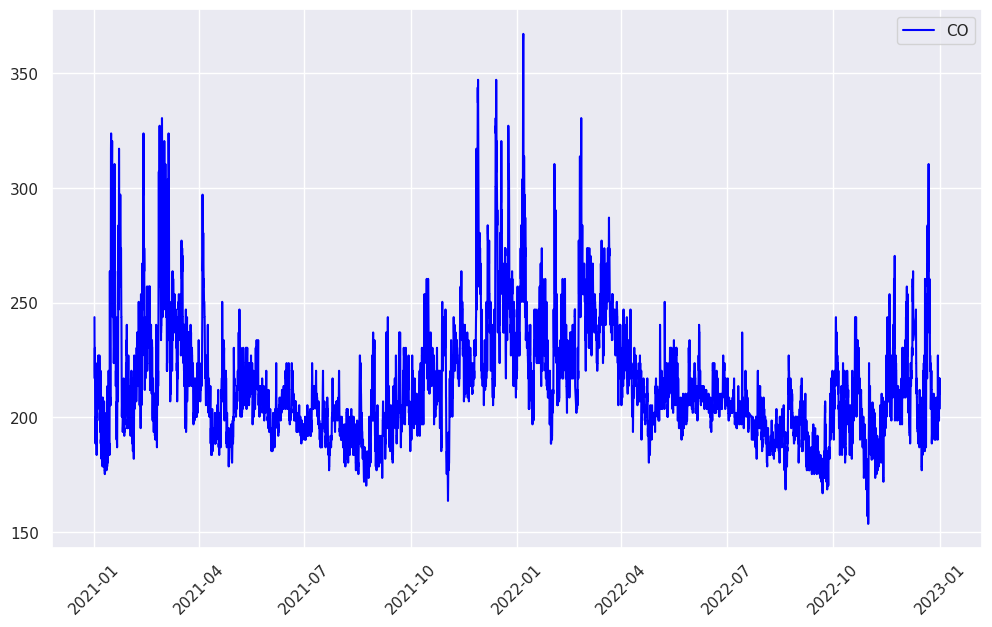

In [85]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(air_pol['date_hour'], air_pol['CO'], color = 'blue', label = 'CO')
plt.legend()
plt.xticks(rotation=45);

In [86]:
air_plot_train = air_pol[air_pol['date_hour']<='2022-10-31 23:00:0']
air_plot_test = air_pol[air_pol['date_hour']>'2022-10-31 23:00:0']

air_plot_train.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'month'], axis = 1, inplace = True)
air_plot_test.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'month'], axis = 1, inplace = True)

air_plot_train.columns = ['y', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','ds', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed']
air_plot_test.columns = ['y', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','ds', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed']

air_plot_train


,y,NO,NO2,O3,SO2,PM2_5,PM10,NH3,ds,temp,feels_like,pressure,humidity,wind_speed
0,243.66,0.0,0.07,41.84,0.07,5.12,11.97,0.41,2021-01-01 00:00:00,9.11,8.43,1007,71,1.70
1,233.65,0.0,0.08,44.35,0.07,5.52,14.40,0.38,2021-01-01 01:00:00,8.46,7.31,1006,73,2.10
2,226.97,0.0,0.08,46.49,0.06,5.83,16.02,0.34,2021-01-01 02:00:00,8.14,6.94,1006,75,2.10
3,223.64,0.0,0.08,46.49,0.06,6.08,16.92,0.30,2021-01-01 03:00:00,6.98,4.51,1006,79,3.60
4,220.30,0.0,0.09,46.49,0.06,6.44,17.89,0.26,2021-01-01 04:00:00,6.89,4.40,1006,80,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16105,223.64,0.0,0.06,14.31,0.02,0.65,0.99,0.26,2022-10-31 19:00:00,20.84,21.25,1019,87,2.57
16106,216.96,0.0,0.07,12.87,0.03,0.76,1.12,0.25,2022-10-31 20:00:00,20.80,21.21,1019,87,2.57
16107,208.62,0.0,0.08,12.70,0.03,0.81,1.12,0.22,2022-10-31 21:00:00,20.74,21.14,1019,87,1.54
16108,205.28,0.0,0.08,13.41,0.03,0.85,1.14,0.20,2022-10-31 22:00:00,20.83,21.08,1020,81,3.60


In [87]:
air_plot_train.dtypes

y                    float64
NO                   float64
NO2                  float64
O3                   float64
SO2                  float64
PM2_5                float64
PM10                 float64
NH3                  float64
ds            datetime64[ns]
temp                 float64
feels_like           float64
pressure               int64
humidity               int64
wind_speed           float64
dtype: object

Con esto anterior hemos comprobado que "y" es un "float64" y que "ds" es "datetime64[ns]"

In [88]:
model = Prophet(holidays_prior_scale=15.0, seasonality_mode='additive', daily_seasonality=True)
model.add_regressor('NO2')
model.add_regressor('O3')
model.add_regressor('SO2')
model.add_regressor('NH3')
model.add_regressor('temp')
model.add_regressor('wind_speed')
model.add_regressor('humidity')
model.add_regressor('NO')
model.fit(air_plot_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2l3t480w/irs6cnk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2l3t480w/4ztkq15o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27039', 'data', 'file=/tmp/tmp2l3t480w/irs6cnk4.json', 'init=/tmp/tmp2l3t480w/4ztkq15o.json', 'output', 'file=/tmp/tmp2l3t480w/prophet_modelynird59s/prophet_model-20231025095152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [89]:
forecast_ts = model.predict(air_plot_test)
forecast_ts = forecast_ts[['ds','yhat','yhat_lower','yhat_upper']]
forecast_ts

,ds,yhat,yhat_lower,yhat_upper
0,2022-11-01 00:00:00,191.490975,168.449476,213.831657
1,2022-11-01 01:00:00,191.465153,168.648305,213.801900
2,2022-11-01 02:00:00,191.735761,168.361651,214.038249
3,2022-11-01 03:00:00,192.159864,169.950359,213.429385
4,2022-11-01 04:00:00,193.024546,170.045931,216.160444
...,...,...,...,...
1411,2022-12-31 20:00:00,187.494357,147.264561,235.092614
1412,2022-12-31 21:00:00,187.153907,144.287390,232.613726
1413,2022-12-31 22:00:00,186.624627,149.474282,232.205545
1414,2022-12-31 23:00:00,186.645981,147.189188,233.299468


In [90]:
forecast_ts = forecast_ts.merge(air_plot_test, on = 'ds', how = 'inner')
forecast_ts[['ds','y','yhat','yhat_lower','yhat_upper','temp','pressure','humidity','wind_speed']]

,ds,y,yhat,yhat_lower,yhat_upper,temp,pressure,humidity,wind_speed
0,2022-11-01 00:00:00,203.61,191.490975,168.449476,213.831657,20.39,1020,81,3.60
1,2022-11-01 01:00:00,200.27,191.465153,168.648305,213.801900,19.92,1019,85,2.57
2,2022-11-01 02:00:00,198.60,191.735761,168.361651,214.038249,19.43,1019,85,3.09
3,2022-11-01 03:00:00,195.26,192.159864,169.950359,213.429385,19.26,1019,84,1.54
4,2022-11-01 04:00:00,195.26,193.024546,170.045931,216.160444,18.91,1019,80,2.57
...,...,...,...,...,...,...,...,...,...
1463,2022-12-31 20:00:00,216.96,187.494357,147.264561,235.092614,14.79,1025,79,4.63
1464,2022-12-31 21:00:00,216.96,187.153907,144.287390,232.613726,14.36,1025,79,2.06
1465,2022-12-31 22:00:00,213.62,186.624627,149.474282,232.205545,14.12,1025,78,2.57
1466,2022-12-31 23:00:00,210.29,186.645981,147.189188,233.299468,13.77,1025,79,2.06


In [91]:
print("MAE: ", metrics.mean_absolute_error(forecast_ts['y'], forecast_ts['yhat']).round(4))
print("MSE: ", metrics.mean_squared_error(forecast_ts['y'], forecast_ts['yhat']).round(4))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(forecast_ts['y'], forecast_ts['yhat'])).round(4))
print("MAPE: ", metrics.mean_absolute_percentage_error(forecast_ts['y'], forecast_ts['yhat']).round(4))

MAE:  21.0792
MSE:  800.9804
RMSE:  28.3016
MAPE:  0.0935


Si miramos el "MAE", es bastante alto pero el "MAPE" no mucho. Igualmente mi conclusión sería que no es bueno.

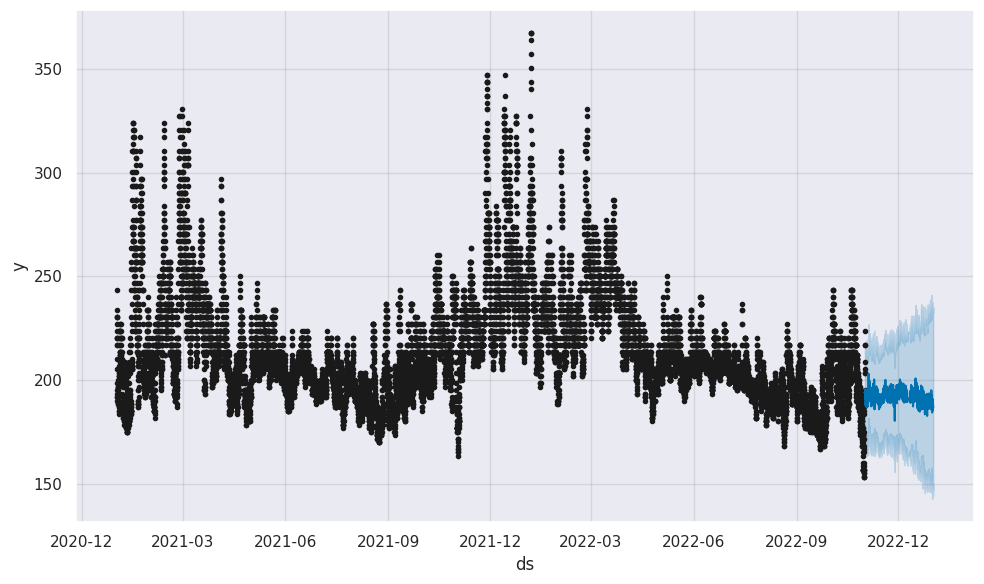

In [92]:
model.plot(forecast_ts)
plt.show()

Como vemos no es una gráfica muy buena porque la parte azul no sigue la misma intención que la parte negra. He probado haciéndolo de distintas formas pero no logro encontrar una buena.

In [93]:
X = air_plot_train['y'].rolling(window=24).mean()
X

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
16105    176.280833
16106    178.367083
16107    180.175417
16108    182.052917
16109    184.000000
Name: y, Length: 16110, dtype: float64

In [94]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
X = air_plot_train['y'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.308560
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Los resultados del ADF test indican que la serie temporal es estacionaria. El p-value extremadamente bajo y la estadística ADF que es mucho menor que los valores críticos sugieren que no hay evidencia de una raíz unitaria en la serie, lo que es un indicador de estacionariedad.